In [1]:
import time
import klepto
import shelve
import pickle
import h5py
import numpy as np
import scipy.io as sio
from scipy.sparse import *
import matplotlib.pyplot as plt

## Load

In [2]:
dataset = '1m'

- load train_list & test_list

In [3]:
feature=h5py.File('movielens/' + dataset + '/test_list.mat')  
test_list = feature['test_list'][:]
test_list = list(map(int, test_list.T[0]))
test_list = [i-1 for i in test_list] 
feature=h5py.File('movielens/' + dataset + '/train_list.mat')  
train_list = feature['train_list'][:]
train_list = list(map(int, train_list.T[0]))
train_list = [i-1 for i in train_list] 

- load full sparse matrix

In [4]:
rating_matrix = load_npz('movielens/sparse_matrix_ml-' + dataset + '_selected.npz').tocsc()
rating_matrix_train = rating_matrix[:, train_list]
rating_matrix_test  = rating_matrix[:, test_list]
print("file load DONE")

file load DONE


- load tree file: lr_bound & tree

In [10]:
with h5py.File('treeFile/lr_bound.mat') as data:
    lr_bound_list = [data[element[0]][:] for element in data['lr_bound']]

depth_threshold = len(lr_bound_list)
i = 0
for i in range(len(lr_bound_list)):
    level = lr_bound_list[i]
    lr_bound_list[i] = []
    level = list((level.T)[0])
    for boundNum in range(0, len(level), 2):
        lr_bound_list[i].append([int(level[boundNum]) - 1, int(level[boundNum + 1]) - 1])
    i += 1

lr_bound = {}
for i in range(len(lr_bound_list)):
    lr_bound[str(i)] = lr_bound_list[i]

In [11]:
feature=h5py.File('treeFile/tree.mat')  
tree = list(feature['tree'][:].T[0])
tree = [i-1 for i in tree]

## MF part

In [12]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS

class MatrixFactorization:
    def __init__(self, maxIter=15, regParam=0.01, rank=10):
        self.maxIter = maxIter
        self.regParam = regParam
        self.rank = rank
        conf = SparkConf().setAppName("appName").setMaster("local[*]")
        conf.set("spark.driver.memory","8g")
        conf.set("spark.executor.memory","8g")
        self.spark = SparkContext.getOrCreate(conf=conf)                    
        print("New SparkSession started...")

    def change_parameter(self, regParam):
        self.regParam = regParam

    def matrix_factorization(self, train_lst):
        ratings = self.spark.parallelize(train_lst)
        model = ALS.train(ratings, self.rank, seed=10, \
                          iterations=self.maxIter, \
                          lambda_=self.regParam)
        print("MF DONE")
        productFeatures = sorted(model.userFeatures().collect(), key=lambda d: d[0], reverse=False)
        userFeatures = sorted(model.productFeatures().collect(), key=lambda d: d[0], reverse=False)
        itemProfile = {each[0]: each[1].tolist() for each in productFeatures}
        userProfile = {each[0]: each[1].tolist() for each in userFeatures}
             
        return userProfile, itemProfile

    def end(self):
        self.spark.stop()
        print("SparkSession stopped.")

In [13]:
lambda_list = [0.005, 0.025, 0.05, 0.075, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.20, 0.25]

In [14]:
MF = MatrixFactorization()

New SparkSession started...


level: 0
Rating Number of level 0: 6040
Current plambda: 0.005
MF DONE
Current RMSE: 1.02892730665
Current plambda: 0.025
MF DONE
Current RMSE: 1.02888378957
Current plambda: 0.05
MF DONE
Current RMSE: 1.02903817214
Current plambda: 0.075
MF DONE
Current RMSE: 1.02969409904
Current plambda: 0.1
MF DONE
Current RMSE: 1.03104686169
Current plambda: 0.11
MF DONE
Current RMSE: 1.03180204603
Current plambda: 0.12
MF DONE
Current RMSE: 1.03268026866
Current plambda: 0.13
MF DONE
Current RMSE: 1.03367933538
Current plambda: 0.14
MF DONE
Current RMSE: 1.03479590064
Current plambda: 0.15
MF DONE
Current RMSE: 1.03602582432
Current plambda: 0.2
MF DONE
Current RMSE: 1.04372391144
Current plambda: 0.25
MF DONE
Current RMSE: 1.05368260066
min RMSE: 1.02888378957


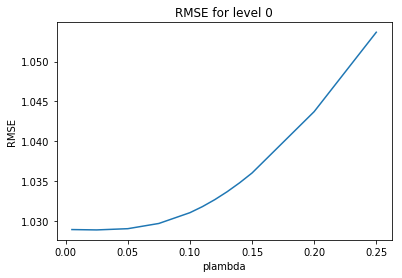

level: 1
Rating Number of level 1: 17950
Current plambda: 0.005
MF DONE
Current RMSE: 0.961505921908
Current plambda: 0.025
MF DONE
Current RMSE: 0.959761168461
Current plambda: 0.05
MF DONE
Current RMSE: 0.958354031197
Current plambda: 0.075
MF DONE
Current RMSE: 0.958110317648
Current plambda: 0.1
MF DONE
Current RMSE: 0.959325864942
Current plambda: 0.11
MF DONE
Current RMSE: 0.960256287695
Current plambda: 0.12
MF DONE
Current RMSE: 0.961444027822
Current plambda: 0.13
MF DONE
Current RMSE: 0.962886706334
Current plambda: 0.14
MF DONE
Current RMSE: 0.964579574733
Current plambda: 0.15
MF DONE
Current RMSE: 0.966516371504
Current plambda: 0.2
MF DONE
Current RMSE: 0.978979841996
Current plambda: 0.25
MF DONE
Current RMSE: 0.995085417028
min RMSE: 0.958110317648


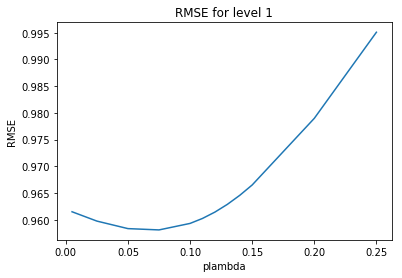

level: 2
Rating Number of level 2: 49786
Current plambda: 0.005
MF DONE
Current RMSE: 0.999457103164
Current plambda: 0.025
MF DONE
Current RMSE: 0.965558106483
Current plambda: 0.05
MF DONE
Current RMSE: 0.95609921628
Current plambda: 0.075
MF DONE
Current RMSE: 0.950783167841
Current plambda: 0.1
MF DONE
Current RMSE: 0.948541551035
Current plambda: 0.11
MF DONE
Current RMSE: 0.948503906643
Current plambda: 0.12
MF DONE
Current RMSE: 0.948946870191
Current plambda: 0.13
MF DONE
Current RMSE: 0.949857531251
Current plambda: 0.14
MF DONE
Current RMSE: 0.951219112092
Current plambda: 0.15
MF DONE
Current RMSE: 0.953011096619
Current plambda: 0.2
MF DONE
Current RMSE: 0.96601723604
Current plambda: 0.25
MF DONE
Current RMSE: 0.982980678423
min RMSE: 0.948503906643


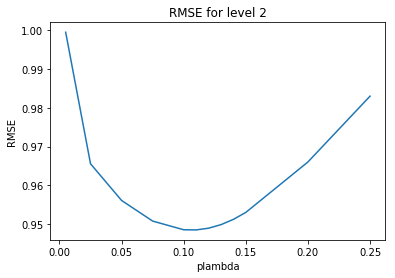

level: 3
Rating Number of level 3: 121347
Current plambda: 0.005
MF DONE
Current RMSE: 1.02029313213
Current plambda: 0.025
MF DONE
Current RMSE: 0.983769756684
Current plambda: 0.05
MF DONE
Current RMSE: 0.965514546118
Current plambda: 0.075
MF DONE
Current RMSE: 0.955344364325
Current plambda: 0.1
MF DONE
Current RMSE: 0.95073089448
Current plambda: 0.11
MF DONE
Current RMSE: 0.950222997456
Current plambda: 0.12
MF DONE
Current RMSE: 0.950393894964
Current plambda: 0.13
MF DONE
Current RMSE: 0.951187309788
Current plambda: 0.14
MF DONE
Current RMSE: 0.952547677851
Current plambda: 0.15
MF DONE
Current RMSE: 0.954427464475
Current plambda: 0.2
MF DONE
Current RMSE: 0.968546099306
Current plambda: 0.25
MF DONE
Current RMSE: 0.986446391174
min RMSE: 0.950222997456


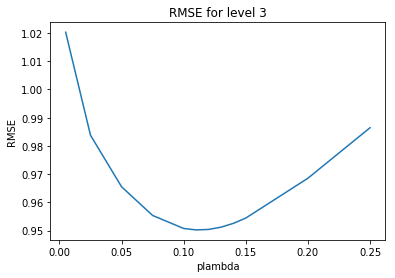

level: 4
Rating Number of level 4: 251781
Current plambda: 0.005
MF DONE
Current RMSE: 1.00712052695
Current plambda: 0.025
MF DONE
Current RMSE: 0.978314308826
Current plambda: 0.05
MF DONE
Current RMSE: 0.960652323343
Current plambda: 0.075
MF DONE
Current RMSE: 0.950698497412
Current plambda: 0.1
MF DONE
Current RMSE: 0.946933411231
Current plambda: 0.11
MF DONE
Current RMSE: 0.946920335783
Current plambda: 0.12
MF DONE
Current RMSE: 0.947652474104
Current plambda: 0.13
MF DONE
Current RMSE: 0.949064072567
Current plambda: 0.14
MF DONE
Current RMSE: 0.95105406322
Current plambda: 0.15
MF DONE
Current RMSE: 0.953399899421
Current plambda: 0.2
MF DONE
Current RMSE: 0.967117145735
Current plambda: 0.25
MF DONE
Current RMSE: 0.984190059187
min RMSE: 0.946920335783


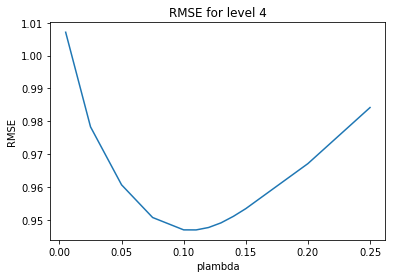

level: 5
Rating Number of level 5: 439742
Current plambda: 0.005
MF DONE
Current RMSE: 1.01312628269
Current plambda: 0.025
MF DONE
Current RMSE: 0.983600059037
Current plambda: 0.05
MF DONE
Current RMSE: 0.963867797865
Current plambda: 0.075
MF DONE
Current RMSE: 0.95276727672
Current plambda: 0.1
MF DONE
Current RMSE: 0.948288944645
Current plambda: 0.11
MF DONE
Current RMSE: 0.947995538014
Current plambda: 0.12
MF DONE
Current RMSE: 0.948421529752
Current plambda: 0.13
MF DONE
Current RMSE: 0.949462967577
Current plambda: 0.14
MF DONE
Current RMSE: 0.950969165161
Current plambda: 0.15
MF DONE
Current RMSE: 0.952769577004
Current plambda: 0.2
MF DONE
Current RMSE: 0.964061132071
Current plambda: 0.25
MF DONE
Current RMSE: 0.978743175494
min RMSE: 0.947995538014


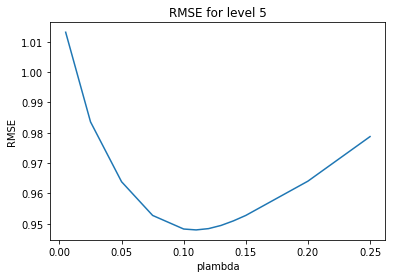

level: 6
Rating Number of level 6: 618255
Current plambda: 0.005
MF DONE
Current RMSE: 1.04746396007
Current plambda: 0.025
MF DONE
Current RMSE: 1.01195726363
Current plambda: 0.05
MF DONE
Current RMSE: 0.990427253856
Current plambda: 0.075
MF DONE
Current RMSE: 0.978154545705
Current plambda: 0.1
MF DONE
Current RMSE: 0.971875556021
Current plambda: 0.11
MF DONE
Current RMSE: 0.970720199051
Current plambda: 0.12
MF DONE
Current RMSE: 0.970279639299
Current plambda: 0.13
MF DONE
Current RMSE: 0.970441898632
Current plambda: 0.14
MF DONE
Current RMSE: 0.971063353577
Current plambda: 0.15
MF DONE
Current RMSE: 0.972101760529
Current plambda: 0.2
MF DONE
Current RMSE: 0.981331411757
Current plambda: 0.25
MF DONE
Current RMSE: 0.994598999166
min RMSE: 0.970279639299


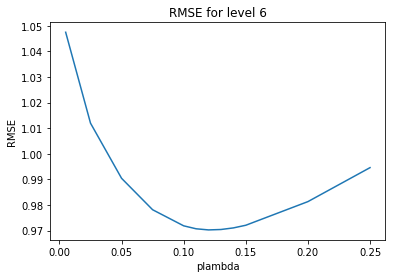

KeyError: "Unable to open object (object 'targetNode' doesn't exist)"

In [15]:
prediction_model = {}
rmst_dict = {"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[],"10":[]}
min_rmse_list = []

for level in range(depth_threshold):
    
    with h5py.File('treeFile/targetNode_' + str(level + 1) + '.mat') as data:
        targetNode = [data[element[0]][:] for element in data['targetNode']]
    with h5py.File('treeFile/rated_user_' + str(level + 1) + '.mat') as data:
        rated_users = [data[element[0]][:] for element in data['rated_user']]
    
    level = str(level)
    print("level:", level)    
                   
    prediction_model.setdefault(level, {})
    train_lst = []    
    
    for pseudo_item_bound, itemid in zip(lr_bound[level], range(len(lr_bound[level]))):
        if pseudo_item_bound[0] > pseudo_item_bound[1]:
            continue
        pseudo_item_lst = tree[pseudo_item_bound[0]:(pseudo_item_bound[1] + 1)]
        pseudo_matrix = np.array(rating_matrix_train[:, pseudo_item_lst].sum(axis=1))[:,0] / \
                                     (rating_matrix_train[:, pseudo_item_lst].getnnz(axis=1)+1e-9)
        train_lst += [(itemid, userid, float(pseudo_matrix[userid])) \
                      for userid in range(pseudo_matrix.shape[0]) if pseudo_matrix[userid]]        

    print("Rating Number of level " + level + ": " + str(len(train_lst)))
    
    #### Train MF and Do validation ####
    min_RMSE = -1
    user_profile_list = []
    item_profile_list = []
    for plambda in lambda_list:
        print("Current plambda: " + str(plambda))
        MF.change_parameter(plambda)
        user_profile, item_profile = MF.matrix_factorization(train_lst)
        user_profile_list.append(user_profile)
        item_profile_list.append(item_profile)
        prediction_model[level]['P'], prediction_model[level]['plambda'] \
                                         = np.dot(np.array(list(user_profile.values())), np.array(list(item_profile.values())).T), plambda
            
        P_test = np.zeros(rating_matrix_test.shape)
        rating_matrix_test_unqueried = rating_matrix_test.toarray()
        for itemid in range(rating_matrix_test.shape[1]):
#             if itemid  % 2000 == 0:
#                 print("%.2f%%" % (100 * itemid / rating_matrix_test.shape[1]))      
            pred_index = int(targetNode[itemid].T[0][1]) - 1
            final_level = int(targetNode[itemid].T[0][0]) - 1
            if rated_users[itemid].sum() == 0 or np.sum(rated_users[itemid] == [1, 0]):
                rated_user = []
            else:
                rated_user = [int(i-1) for i in list(set(rated_users[itemid][0]))]
                
            P_test[:, itemid] = prediction_model[str(final_level)]['P'][:, pred_index]
            rating_matrix_test_unqueried[rated_user, itemid] = 0

        rating_matrix_test_unqueried = csc_matrix(rating_matrix_test_unqueried)
        P_test = (rating_matrix_test_unqueried!=0).multiply(P_test)
        dif = P_test - rating_matrix_test_unqueried
        RMSE = ( dif.multiply(dif).sum() / (rating_matrix_test_unqueried!=0).sum() )**0.5
        print("Current RMSE: " + str(RMSE))
        rmst_dict[level].append(RMSE)
        
    min_MF = rmst_dict[level].index(min(rmst_dict[level]))   
    prediction_model[level]['upro'] = user_profile_list[min_MF]
    prediction_model[level]['ipro'] = item_profile_list[min_MF]
    prediction_model[level]['plambda'] = lambda_list[min_MF]
    print("min RMSE: " + str(min(rmst_dict[level])))
    min_rmse_list.append(min(rmst_dict[level]))
    
    plt.figure(1)
    plt.title('RMSE for level ' + level)
    plt.xlabel('plambda')
    plt.ylabel('RMSE')
    plt.plot(lambda_list, rmst_dict[level])
    plt.show()

In [12]:
MF.end()

SparkSession stopped.


In [25]:
import klepto
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)
Tree['prediction_model'] = prediction_model
Tree.dump()
Tree.clear()

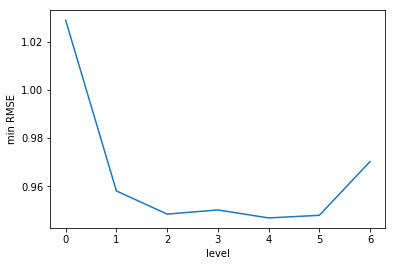

In [16]:
plt.figure(1)
plt.xlabel('level')
plt.ylabel('min RMSE')
plt.plot(list(range(depth_threshold)), min_rmse_list)
plt.show()

In [68]:
for i in range(depth_threshold):
    sio.savemat('rmse_list' + str(i) + '.mat', {'rmse_list': rmst_dict[str(i)]})

In [69]:
sio.savemat('min_rmse_list.mat', {'min_rmse_list':min_rmse_list})

In [17]:
min_rmse_list

[1.0288837895681577,
 0.95811031764837662,
 0.94850390664269291,
 0.95022299745623195,
 0.9469203357825049,
 0.94799553801395997,
 0.97027963929850669]